In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import rv_continuous
from astroquery.gaia import Gaia

In [2]:
# Define some distribution for the priors
# Uniform prior has already built-in scipy.stats.uniform

# Constant Volume Density
class ConstantDensity_gen(rv_continuous):
    r"""A constant density continuous random variable.

    In the standard form, the distribution is proportional to r^2 on ``[0, 1]``. Using
    the parameters ``loc`` and ``scale``, one obtains the distribution
    on ``[loc, loc + scale]``.
    """
    def _pdf(self, x):
        return 3*np.power(x, 2)

    def _logpdf(self, x):
        return np.log(3)+2*np.log(x)

    def _cdf(self, x):
        return np.power(x, 3)
    
    def _logcdf(self, x):
        return 3*np.log(x)

    def _ppf(self, x):
        return np.power(x, 1/3)

    def __sf(self, x):
        return 1 - np.power(x, 3)

    def _logsf(self, x):
        return np.log(1 - np.power(x, 3))
    
    def _isf(self, x):
        return np.power(1-x, 1/3)
        
constantDensity = ConstantDensity_gen(a=0.0, b=1.0, name='constant_density')

# # Exponentially Decreasing
class ExponentiallyDecreasing_gen(rv_continuous):
    r"""An exponentially decreasing continuous random variable.

    The location (``loc``) keyword specifies the zero-distance.
    The scale (``scale``) keyword specifies the scale length.

    %(before_notes)s

    Notes
    -----
    The probability density function for `exponentially decreasing` is:

    .. math::

        f(x) = \frac{x^2\exp(-x/L)}{3L^{3}}

    for a positive real number :math:`x` 
    and positive real number :math:`x`.

    %(after_notes)s
    """
    def _pdf(self, x):
        return np.exp(-x)*np.power(x, 2)/2

    def _logpdf(self, x):
        return 2*np.log(x)-x-np.log(3)

    def _cdf(self, x):
        return 1/3*(2-np.exp(-x)*(x*(x+2)+2))
    
    def _logcdf(self, x):
        return np.log((2-np.exp(-x)*(x*(x+2)+2))) - np.log(3)
        
exponentiallyDecreasing = ExponentiallyDecreasing_gen(a=0.0, name='exponentially_decreasing')

In [3]:
# Grab data from Gaia DR2
job = Gaia.launch_job_async(""" 
SELECT TOP 2000 *
FROM gaiadr2.gaia_source
WHERE parallax > 0 AND (random_index BETWEEN 12345 AND 56789)
""")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
# See the columns
r.colnames

['solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [6]:
# Check what's in it
r[["SOURCE_ID", "parallax", "parallax_error"]]

SOURCE_ID,parallax,parallax_error
,mas,mas
int64,float64,float64
2027838817078343808,0.43243125624106177,0.12165888759411657
4161933574533589888,3.264891413120491,3.362813363303925
4072990574296090368,0.26449423937762556,0.15245530336289018
2032725596523174144,0.26907084701226136,0.0902095990171838
4105959219961581440,0.29983693271213413,0.0729436495693375
5932609296381196032,4.649485451899394,1.5348297532832427
5720850778475448576,5.53139684876496,2.306038067982972
5621586250253312512,0.3304770627176499,0.08232640302471737


In [8]:
# Add new column, relative error
r["f"]= r["parallax_error"]/r["parallax"]
r[["SOURCE_ID", "parallax", "parallax_error", "f"]]

SOURCE_ID,parallax,parallax_error,f
,mas,mas,
int64,float64,float64,float64
2027838817078343808,0.43243125624106177,0.12165888759411657,0.2813369427817146
4161933574533589888,3.264891413120491,3.362813363303925,1.0299924064212118
4072990574296090368,0.26449423937762556,0.15245530336289018,0.5764031145692577
2032725596523174144,0.26907084701226136,0.0902095990171838,0.3352633702939695
4105959219961581440,0.29983693271213413,0.0729436495693375,0.24327773403208086
5932609296381196032,4.649485451899394,1.5348297532832427,0.3301074428905329
5720850778475448576,5.53139684876496,2.306038067982972,0.41689976890699143
5621586250253312512,0.3304770627176499,0.08232640302471737,0.24911381851349446


In [9]:
# Sort by relative error
r.sort("f")
r[["SOURCE_ID", "parallax", "parallax_error", "f"]]

SOURCE_ID,parallax,parallax_error,f
,mas,mas,
int64,float64,float64,float64
215287851349184512,2.800231251651043,0.022593363015767472,0.008068391852439405
5563497882720528768,2.400647754778993,0.023603974523109514,0.009832335658624158
5571494218471085184,2.2564500640313887,0.023786713091161954,0.010541652780325417
3026973485713987584,2.561201909336577,0.027190187500150443,0.010616182738671103
3587187751119645440,4.153332859383128,0.04552114664433956,0.010960148917874252
5123452850878106752,2.289140480844756,0.030048862212181362,0.013126700813526525
5373961525708351104,1.3157375846059942,0.017609080969650255,0.013383429321830466
1924354191396309504,1.3233438932901307,0.01818030236562608,0.013738154124417166


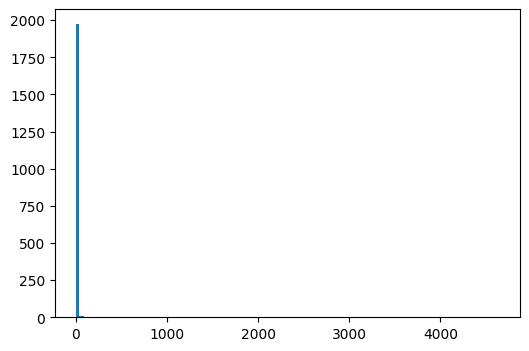

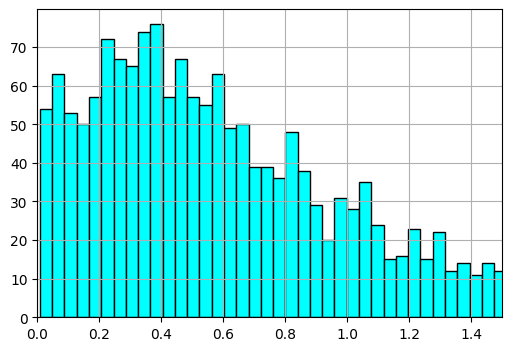

In [10]:
# Sneak peek relative error distribution
plt.figure(figsize=(6,4))
plt.hist(r["f"], bins=150)
plt.show()

# See only f < 2
plt.figure(figsize=(6,4))
plt.hist(r["f"][r["f"]<2], bins=50, edgecolor="k", color="aqua")
plt.xlim(0,1.5)
plt.grid()
plt.show()

In [12]:
# Init Data, just change the index as you like
index = int(input()) 
# index = 50
parallax = r["parallax"][index]/1000
parallax_error = r["parallax_error"][index]/1000
f = r["f"][index]
source_id = r["SOURCE_ID"][index]

# Preliminary 
## Trust me, rmax = 15_000 pc is reasonable
rmax = 1.5E4
distance = np.linspace(1, rmax, 10000)
## Likelihood function, see Bailer-Jones
likelihood = norm.pdf(x=1/distance, scale=parallax_error, loc=parallax)
normalization, _ = integrate.quad(lambda t: norm.pdf(x=1/t, scale=parallax_error, loc=parallax), a=0, b=rmax)
likelihood /= normalization

# Prior 1, Uniform
prior1 = uniform.pdf(x=distance, scale=rmax)
posterior1 = prior1*likelihood
posterior1_norm = integrate.simps(posterior1, distance)
posterior1 /= posterior1_norm

# Prior 2, Constant Volume Density
prior2 = constantDensity.pdf(x=distance, scale=rmax)
posterior2 = prior2*likelihood
posterior2_norm = integrate.simps(posterior2, distance)
posterior2 /= posterior2_norm

# Prior 3, Exponentially Decreasing
## scale length 1_000, seems reasonable
rlen = 1E3
prior3 = exponentiallyDecreasing.pdf(x=distance, scale=rlen)
posterior3 = prior3*likelihood
posterior3_norm = integrate.simps(posterior3, distance)
posterior3 /= posterior3_norm

## Print the data that being used
print("source_id: ", source_id)
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", f)

source_id:  427052691356599168
parallax (mas) =  4.129056328751408
parallax_error (mas) =  0.9139759012615534
f =  0.22135224818740415


C:\Users\alisyaifudin\AppData\Local\Temp\ipykernel_13412\64687861.py:21: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior1_norm = integrate.simps(posterior1, distance)
C:\Users\alisyaifudin\AppData\Local\Temp\ipykernel_13412\64687861.py:27: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior2_norm = integrate.simps(posterior2, distance)
C:\Users\alisyaifudin\AppData\Local\Temp\ipykernel_13412\64687861.py:35: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior3_norm = integrate.simps(posterior3, distance)


source_id:  427052691356599168
parallax (mas) =  4.129056328751408
parallax_error (mas) =  0.9139759012615534
f =  0.22135224818740412


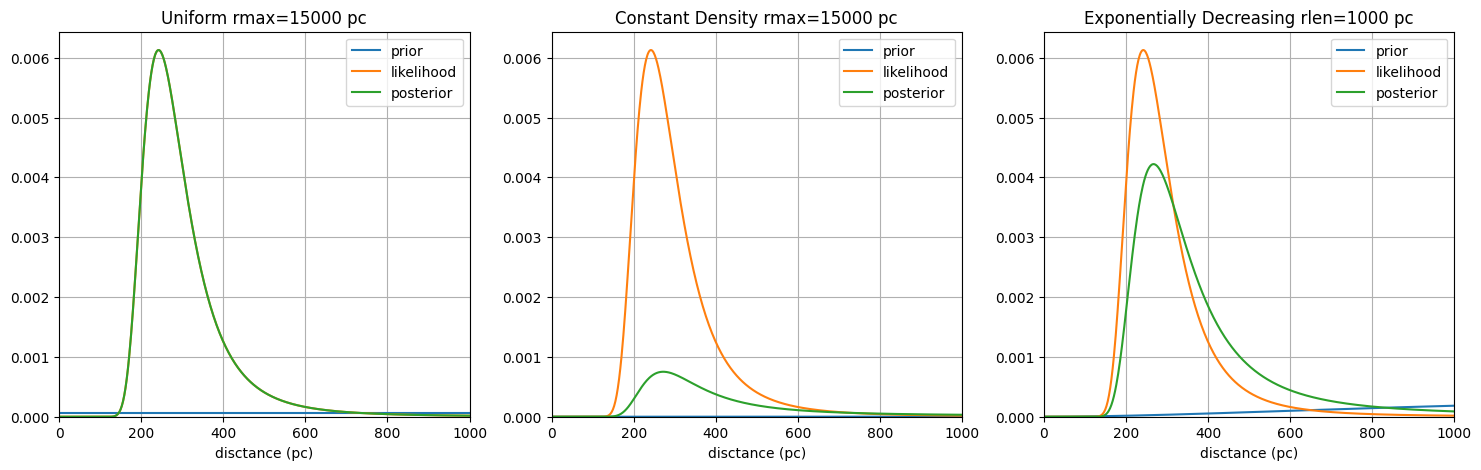

In [14]:
## Print the data that being used
print("source_id: ", source_id)
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", parallax_error/parallax)
xLim = float(input(f"max x-lim plot (<{rmax:.0f})"))
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(distance, prior1, label="prior")
ax1.plot(distance, likelihood, label="likelihood")
ax1.plot(distance, posterior1, label="posterior")
ax1.legend(loc="best")
ax1.grid()
ax1.set_xlim(0, xLim)
ax1.set_ylim(0)
ax1.set_xlabel("disctance (pc)")
ax1.set_title(f"Uniform rmax={int(rmax)} pc")

ax2.plot(distance, prior2, label="prior")
ax2.plot(distance, likelihood, label="likelihood")
ax2.plot(distance, posterior2, label="posterior")
ax2.legend(loc="best")
ax2.grid()
ax2.set_xlim(0, xLim)
ax2.set_ylim(0)
ax2.set_xlabel("disctance (pc)")
ax2.set_title(f"Constant Density rmax={int(rmax)} pc")

ax3.plot(distance, prior3, label="prior")
ax3.plot(distance, likelihood, label="likelihood")
ax3.plot(distance, posterior3, label="posterior")
ax3.legend(loc="best")
ax3.grid()
ax3.set_xlim(0, xLim)
ax3.set_ylim(0)
ax3.set_xlabel("disctance (pc)")
ax3.set_title(f"Exponentially Decreasing rlen={int(rlen)} pc")

plt.show()

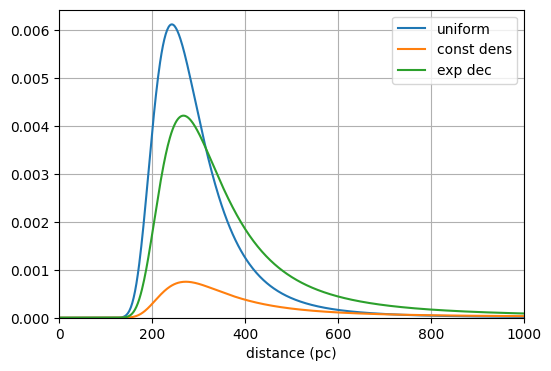

In [15]:
# Create interpolation function for posterior, just in case
from scipy import interpolate
p1 = interpolate.interp1d(distance, posterior1, kind="cubic")
p2 = interpolate.interp1d(distance, posterior2, kind="cubic")
p3 = interpolate.interp1d(distance, posterior3, kind="cubic")

# Plot all posteriors in one figure
plt.figure(figsize=(6,4))
plt.plot(distance, p1(distance), label="uniform")
plt.plot(distance, p2(distance), label="const dens")
plt.plot(distance, p3(distance), label="exp dec")
plt.legend(loc="best")
plt.grid()
plt.xlim(0, xLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.show()


In [16]:
# Find percentile {perc}% of normalized distribution
def percentile(func, perc=0.5, min=0, max=1):
  r""" Find percentile {perc}% of normalized distribution
  perc: percentile
  min: min x-value
  max: max x-value
  """
  start = min
  end = rmax
  for k in range(5):
    dist = np.linspace(start, end, 10)
    for i in range(10):
      # print(dist[i])
      val, _ = integrate.quad(func, a=min, b=dist[i])
      if val > perc: break
    start = dist[i-1]
    end = dist[i]
  return (start+end)/2

In [17]:
# Highest density interval of {perc}% of normalized distribution
def hdi(func, perc=0.68, res=1E3, min=0.0, max=1.0):
  r""" Highest density interval of {perc}% of normalized distribution
  perc: percentile
  res: resolution, number of sampling from distributiion
  min: min x-value
  max: max x-value
  """
  x = np.linspace(min, max, int(res))
  y = func(x)
  upper = np.max(y)*0.99
  below = 0
  for k in range(10):
    ys = np.linspace(upper, below, 10)
    for i in range(10):
      mask = y > ys[i]
      x_mask = x[mask]
      integral, _ = integrate.quad(func, a=x_mask[0], b=x_mask[-1])
      if(integral > perc): break
    upper = ys[i-1]
    below = ys[i]
    xMin = x_mask[0]
    xMax = x_mask[-1]
  return (xMin, xMax)

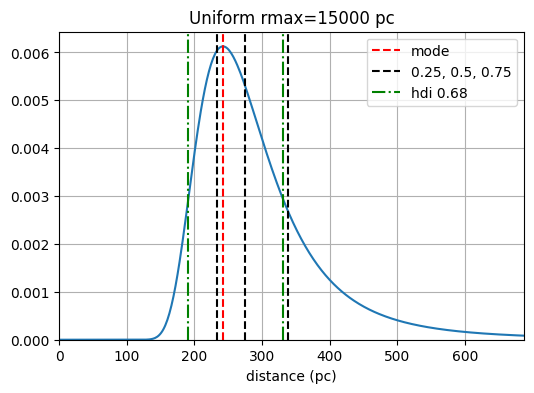

mode = 243 pc
25% = 233 pc
50% = 275 pc
75% = 339 pc
hdi = 191-332 pc
hdi = +89/-52 pc


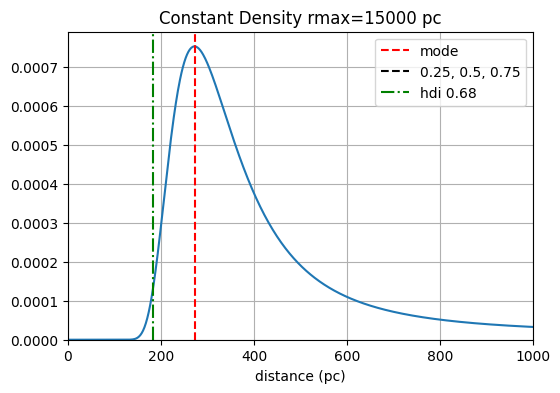

mode = 273 pc
25% = 4166 pc
50% = 9934 pc
75% = 12871 pc
hdi = 183-15000 pc
hdi = +14727/-89 pc


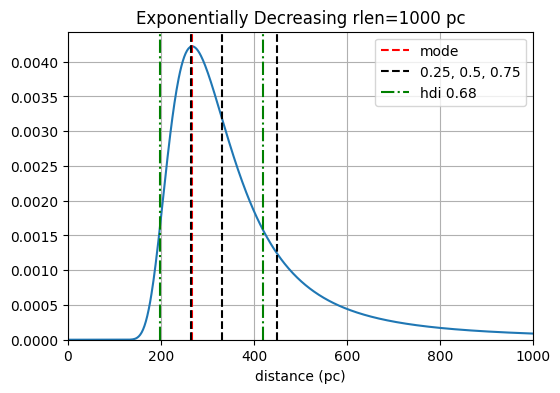

mode = 267 pc
25% = 265 pc
50% = 330 pc
75% = 450 pc
hdi = 197-420 pc
hdi = +153/-69 pc


In [18]:
### Uniform
mode = distance[np.argmax(posterior1)]
q50 = percentile(p1, perc=0.5, min=1, max=rmax)
q25 = percentile(p1, perc=0.25, min=1, max=rmax)
q75 = percentile(p1, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p1, perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = xLim
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(distance, p1(distance))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Uniform rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")

### Const Dens
mode = distance[np.argmax(posterior2)]
q50 = percentile(p2, perc=0.5, min=1, max=rmax)
q25 = percentile(p2, perc=0.25, min=1, max=rmax)
q75 = percentile(p2, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p2, perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = xLim
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(distance, p2(distance))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Constant Density rmax={int(rmax)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")

### Exp Dec
mode = distance[np.argmax(posterior3)]
q50 = percentile(p3, perc=0.5, min=1, max=rmax)
q25 = percentile(p3, perc=0.25, min=1, max=rmax)
q75 = percentile(p3, perc=0.75, min=1, max=rmax)
hdi_perc = 0.68
hdi_below, hdi_upper = hdi(p3, perc=hdi_perc, res=1E5, min=1.0, max=rmax)
x_upperLim = xLim
x_lowerLim = 0
if((hdi_upper-mode)*5+mode < x_upperLim): x_upperLim = (hdi_upper-mode)*5 + mode
if(mode - (mode-hdi_below)*5 > x_lowerLim): x_lowerLim = mode - (mode-hdi_below)*5

plt.figure(figsize=(6,4))
plt.plot(distance, p3(distance))
plt.grid()
plt.xlim(x_lowerLim, x_upperLim)
plt.ylim(0)
plt.xlabel("distance (pc)")
plt.title(f"Exponentially Decreasing rlen={int(rlen)} pc")
plt.axvline(mode, ls="--", c="r", label="mode")
plt.axvline(q25, ls="--", c="k", label="0.25, 0.5, 0.75")
plt.axvline(q50, ls="--", c="k")
plt.axvline(q75, ls="--", c="k")
plt.axvline(hdi_below, ls="-.", c="g", label=f"hdi {hdi_perc}")
plt.axvline(hdi_upper, ls="-.", c="g")
plt.legend()
plt.show()
print(f"mode = {mode:.0f} pc")
print(f"25% = {q25:.0f} pc")
print(f"50% = {q50:.0f} pc")
print(f"75% = {q75:.0f} pc")
print(f"hdi = {hdi_below:.0f}-{hdi_upper:.0f} pc")
print(f"hdi = +{(hdi_upper-mode):.0f}/-{(mode-hdi_below):.0f} pc")